In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation 
from matplotlib import colors
from celluloid import Camera

In [2]:
def move(location, lattice):
    state = lattice[location]
    direction = np.random.randint(4)

    #move up, y < n - 1
    if direction == 0 and location[1] < len(lattice[0]) - 1:
        if lattice[(location[0],location[1]+1)] == 0:
            lattice[(location[0],location[1]+1)] = state
            lattice[location] = 0
    #move down, y > 0
    if direction == 1 and location[1] > 0:
        if lattice[(location[0],location[1]-1)] == 0:
            lattice[(location[0],location[1]-1)] = state
            lattice[location] = 0
    #move right, x < n - 1
    if direction == 2 and location[0] < len(lattice) - 1:
        if lattice[(location[0]+1,location[1])] == 0:
            lattice[(location[0]+1,location[1])] = state
            lattice[location] = 0
    #move left, x > 0
    if direction == 3 and location[0] > 0:
        if lattice[(location[0]-1,location[1])] == 0:
            lattice[(location[0]-1,location[1])] = state
            lattice[location] = 0

def infect(location, lattice):
    direction = np.random.randint(4)

    #infect up, y < n - 1
    if direction == 0 and location[1] < len(lattice) - 1:
        if lattice[(location[0],location[1]+1)] == 1:
            lattice[(location[0],location[1]+1)] = 2
    #infect down, y > 0
    if direction == 1 and location[1] > 0:
        if lattice[(location[0],location[1]-1)] == 1:
            lattice[(location[0],location[1]-1)] = 2
    #infect right, x < n - 1
    if direction == 2 and location[0] < len(lattice) - 1:
        if lattice[(location[0]+1,location[1])] == 1:
            lattice[(location[0]+1,location[1])] = 2
    #infect left, x > 0
    if direction == 3 and location[0] > 0:
        if lattice[(location[0]-1,location[1])] == 1:
            lattice[(location[0]-1,location[1])] = 2

def get_random_agent_location(lattice, infectedOnly=False):
    if infectedOnly:
        individuals = np.where(lattice==2)
    else:
        individuals = np.where(lattice!=0)
    
    #print(np.random.randint(len(individuals[0])))
    random_individual_index = np.random.randint(len(individuals[0]))
    location = (individuals[0][random_individual_index], individuals[1][random_individual_index])
    return location

In [ ]:
def SIR_ABM(pi = 0.1, pm = 1.0, pr = 0.01, n = 20, s0 = 0.49, i0 = 0.01, r0 = 0.00, snapshot_num = 600):

    #initialise array with individuals (S = 1, I = 2, R = 3)
    #1d array with required number of individuals
    A = np.zeros((n**2))
    S_num = int(np.ceil(s0 * n**2))
    I_num = int(np.ceil(i0 * n**2))
    R_num = int(np.ceil(r0 * n**2))
    A[:S_num] = 1
    A[S_num:S_num+I_num] = 2
    A[S_num + I_num:S_num + I_num + R_num] = 3
    #shuffle and reshape to 2d
    np.random.shuffle(A)
    A = A.reshape(n,n)

    #time
    t = 0
    max_time = 5/pr

    #lists, st is list of indexes of snapshot times, so that t[st[i]] gives time of i'th snapshot of A
    t_list = [t]
    S_list = [S_num]
    I_list = [I_num]
    R_list = [R_num]
    A_list = [np.copy(A)]
    st_list = [t]

    #snapshot
    snapshot_count = 0
    count = 0

    while t < max_time:
        #decide which event takes place and advance time
        a = pm*(S_num+I_num+R_num) + pi*I_num + pr*I_num
        step = -np.log(np.random.uniform())/a
        t += step
        event = a*np.random.uniform()

        if event <= pm*(S_num+I_num+R_num):
            #movement
            loc = get_random_agent_location(A)
            move(loc, A)
        elif (pm*(S_num+I_num+R_num) < event) and  (event <= pm*(S_num+I_num+R_num) + pi*I_num):
            #infection
            loc = get_random_agent_location(A, infectedOnly=True)
            infect(loc, A)
        elif (pm*(S_num+I_num+R_num) + pi*I_num < event) and  (event <= pm*(S_num+I_num+R_num) + pi*I_num + pr*I_num):
            #recovery
            loc = get_random_agent_location(A, infectedOnly=True)
            A[loc] = 3
        
        count += 1

        S_num = np.sum(A==1)
        I_num = np.sum(A==2)
        R_num = np.sum(A==3)

        t_list.append(t)
        S_list.append(S_num)
        I_list.append(I_num)
        R_list.append(R_num)
        if t > snapshot_count*max_time/snapshot_num:
            A_list.append(np.copy(A))
            st_list.append(count)
            snapshot_count+=1

    return S_list, I_list, R_list, t_list, A_list, st_list

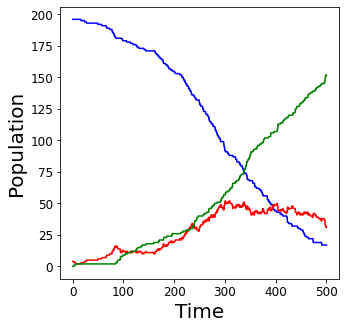

In [92]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Population', fontsize=20)
ax.tick_params(axis='both', labelsize=12)
S, I, R, t, A, st = SIR_ABM(n=20)
ax.plot(t[::4],S[::4], 'blue')
ax.plot(t[::4],I[::4], 'red')
ax.plot(t[::4],R[::4], 'green')

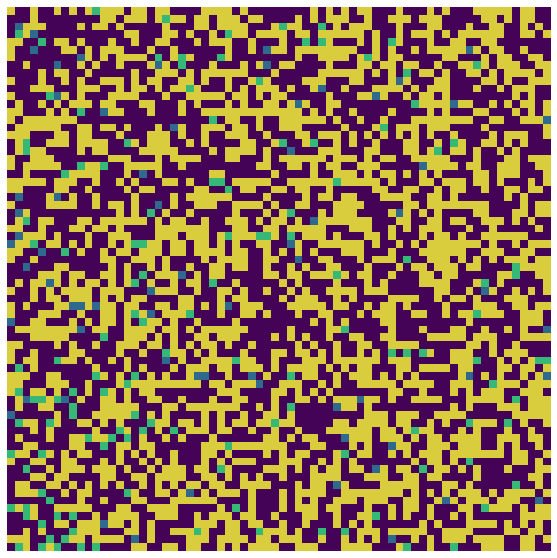

In [277]:
##anim of lattice

A_list = SIR_ABM(n=70)[4]
fig = plt.figure(figsize=(10,10))
plt.axis('off')
camera=Camera(fig)
for copy in A_list:
    if len(np.where(copy==3)[0])==0:
        cmap = colors.ListedColormap(['#440357','#d9cd3d','#36B877'])
    else:
        cmap = colors.ListedColormap(['#440357','#d9cd3d','#36B877','#2F698D'])
    plt.imshow(copy, cmap=cmap)
    camera.snap()

anim = camera.animate()
anim.save('anims/test28.mp4', fps=30)

In [93]:
S, I, R, t, A_list, st = SIR_ABM(n=60, snapshot_num=60)

In [83]:
##anim lattice + sir graph

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.axis('off')
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Population', fontsize=20)
ax.tick_params(axis='both', labelsize=12)
camera = Camera(fig)

for i in range(len(st)):
    if len(np.where(A_list[i]==3)[0])==0:
        cmap = colors.ListedColormap(['#440357','#2F698D','#36B877'])
    else:
        cmap = colors.ListedColormap(['#440357','#2F698D','#36B877','#d9cd3d'])
    ax1.imshow(A_list[i], cmap=cmap)
    j = st[i]
    susc, = ax2.plot(t[:j], S[:j], '#2F698D')
    inf, = ax2.plot(t[:j], I[:j], '#36B877')
    rec, = ax2.plot(t[:j], R[:j], '#8c8c01')
    ax2.legend([susc, inf, rec],['Susceptible', 'Infected', 'Recovered'])

    camera.snap()


Error in callback <function flush_figures at 0x000002464C0FFF70> (for post_execute):


KeyboardInterrupt: 

In [77]:
anim = camera.animate()
mywriter = animation.FFMpegWriter(fps=15, bitrate=5000)

In [80]:
anim.save('anims/test37.mp4', writer=mywriter)